(674, 674)


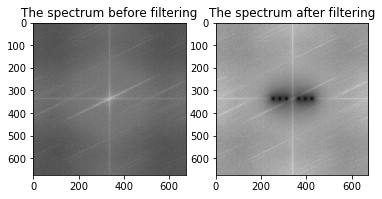

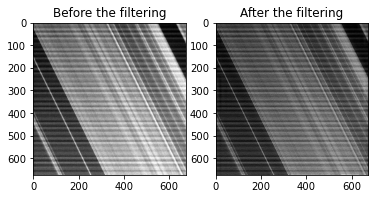

In [10]:
import cv2
import numpy as np
import scipy
from matplotlib import pyplot as plt

def notch_filter(filename = 'b.tif'):
    # get image information
    img = cv2.imread(filename, 0)
    Height_original, Width_original = np.shape(img)    # 获取宽高信息

    #   parameter
    N = 4
    D0k = 2

    #   DFT
    img_float32 = np.float32(img)
    # dft = cv2.dft(img_float32, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)

    # 频谱图像双通道复数转换为0-255区间
    # magitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    magitude_spectrum = 20*np.log(np.abs(dft_shift))
    magitude_spectrum_int = np.zeros((Height_original, Width_original), dtype='uint8')
    for x in range(Height_original):
        for y in range(Width_original):
            index = np.int(magitude_spectrum[x][y])
            # if index > 128:
            #             #     index = 128
            #             # elif index < 0:
            #             #     index = 0
            #             #     pass
            magitude_spectrum_int[x][y] = index
            pass
        pass

    # 标记图片亮点坐标
    def mouse(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            xy = "%d,%d" % (x, y)
            cv2.circle(img, (x, y), 1, (255, 255, 255), thickness=-1)
            cv2.putText(img, xy, (x-25, y-25), cv2.FONT_HERSHEY_PLAIN,
                        1.0, (255, 255, 255), thickness=1)
            cv2.imshow("image", img)

    print(np.shape(magitude_spectrum_int))
    img = magitude_spectrum_int
    cv2.namedWindow("image")
    cv2.imshow("image", img)
    # cv2.resizeWindow("image", 800, 600)
    cv2.setMouseCallback("image", mouse)
    #  显示频谱图
    # cv2.waitKey(0)
    cv2.destroyAllWindows()

    plt.figure(1)
    plt.subplot(121)
    plt.title('The spectrum before filtering')
    plt.imshow(magitude_spectrum, cmap = 'gray')
    # plt.show()
    '''
    亮点坐标
    (426, 182)   |    (426, 294) 
    (426, 212)   |    (426, 323)
    (426, 240)   |    (426, 352)
    '''
    p1 = (0, 85)
    p2 = (0, 56)
    p3 = (0, 27)

    centerX = np.floor(Height_original / 2)  # 426.0
    centerY = np.floor(Width_original / 2)   # 268.0

    # 构建滤波器传递函数H_NR

    H_NR = np.ones((Height_original, Width_original))
    Dk = np.zeros((2, 3))

    for u in range(Height_original):
        for v in range(Width_original):
            Dk[0][0] = np.sqrt((u-centerX-p1[0])**2 + (v-centerY-p1[1])**2)
            Dk[0][1] = np.sqrt((u - centerX - p2[0]) ** 2 + (v - centerY - p2[1])**2)
            Dk[0][2] = np.sqrt((u - centerX - p3[0]) ** 2 + (v - centerY - p3[1])**2)

            Dk[1][0] = np.sqrt((u-centerX+p1[0])**2 + (v-centerY+p1[1])**2)
            Dk[1][1] = np.sqrt((u - centerX + p2[0]) ** 2 + (v - centerY + p2[1])**2)
            Dk[1][2] = np.sqrt((u - centerX + p3[0]) ** 2 + (v - centerY + p3[1])**2)

            for i in Dk[0]:
                H_NR[u][v] = H_NR[u][v] * (1/(1 + D0k/(i+0.01)))**N
                pass
            for i in Dk[1]:
                H_NR[u][v] = H_NR[u][v] * (1/(1 + D0k/(i+0.01)))**N
                pass
            pass
        pass

    # IDFT

    Gs = magitude_spectrum * H_NR

    plt.figure(1)
    plt.subplot(122)
    plt.title('The spectrum after filtering')
    plt.imshow(Gs, cmap = 'gray')

    G = dft_shift * H_NR

    iimg = np.fft.ifft2(G)
    iimg = np.abs(iimg)


    plt.figure(2)
    plt.subplot(121)
    plt.title('Before the filtering')
    plt.imshow(img_float32, cmap = 'gray')
    plt.subplot(122)
    plt.title('After the filtering')
    plt.imshow(iimg, cmap = 'gray')
    plt.show()


if __name__ == '__main__':
    notch_filter()